In [1]:
## to run change the inference file output last line 

In [2]:
import sys
sys.path.append('/home/punygod_admin/SoundSense/soundsense')

In [3]:
import torch
from sklearn.manifold import TSNE
from torchvision.models.feature_extraction import create_feature_extractor
import matplotlib.pyplot as plt
from matplotlib import patches
import torch.nn as nn
from models.baselines.mulsa.inference import MULSAInference
from models.baselines.mulsa.src.models.encoders import (
    make_vision_encoder,
    make_audio_encoder,
)
from models.baselines.mulsa.src.models.imi_models import Actor
from models.baselines.mulsa.src.engines.engine import ImiEngine
from models.imi_datasets import ImitationEpisode
import numpy as np
import os
import yaml
from torch.utils.data import DataLoader

/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-24 21:12:48.490806: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def tsne_plot(config, model, seq_len = 0, device='cuda'):

    np.random.seed(0)
    run_ids = os.listdir('/home/punygod_admin/SoundSense/soundsense/data/mulsa/sorting')
    np.random.permutation(run_ids)
    train_val_split = 0.8
    split = int(train_val_split*len(run_ids))
    train_episodes = run_ids[:split]
    val_episodes = run_ids[split:]

    print("Train episodes: ", len(train_episodes))
    print("Val episodes: ", len(val_episodes))
    val_set = torch.utils.data.ConcatDataset(
        [
            ImitationEpisode(config, run_id, train=False)
            for run_id in val_episodes
        ]
    )

    val_loader = DataLoader(val_set, num_workers=config["num_workers"], shuffle=False,batch_size=1)

    outputs_list = []
    targets_list = []
    indices = []

    for i, (img, target) in enumerate(val_loader):
        img[0] = img[0].squeeze(0)
        img[0] = img[0].permute(0, 2, 3, 1)
        # print(img[1].squeeze(0).shape)
        inp = {"video": np.array(img[0]), "audio": img[1].squeeze(0).to(device)}  
        if i > 999:
            break
        with torch.no_grad():
            output  = model(inp)
        outputs_list.append(output)
        if seq_len:
            targets_list.append(target[0][0][-1,].unsqueeze(0))
        else:
            targets_list.append(target[0][0])
        indices.append(i)
        
    
    outputs = torch.cat(outputs_list, dim=0)
    targets = torch.cat(targets_list, dim=0)
    print("before", outputs.shape, targets.shape)
    outputs = outputs.view(outputs.size(0), -1).cpu().numpy()
    targets = targets.cpu().numpy()
    print("after",outputs.shape, targets.shape)

    # if seq_len:
    #     targets = targets[:1000,:]
    
    tsne = TSNE(n_components=2)
    features_tsne = tsne.fit_transform(outputs)
    features_tsne.shape

    class_colors = plt.cm.tab20(np.arange(8))

    plt.figure(figsize=(10, 8))
    i = 0
    for i in range(8):
        indices = np.where(targets[:, i] == 1)[0]
        plt.scatter(features_tsne[indices, 0], features_tsne[indices, 1], label=f"Class {i}", color=class_colors[i])

    plt.title('t-SNE Projection of Features with Ground Truth Labels')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Object Class', bbox_to_anchor=(1.05, 1), loc='upper left')  

### sorting_imi_vg_simple_seqlen_1_spec

/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


Using GPU
Creating simple decoder
Total parameters: 26.662024 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


before torch.Size([1000, 256]) torch.Size([1000, 8])
after (1000, 256) (1000, 8)


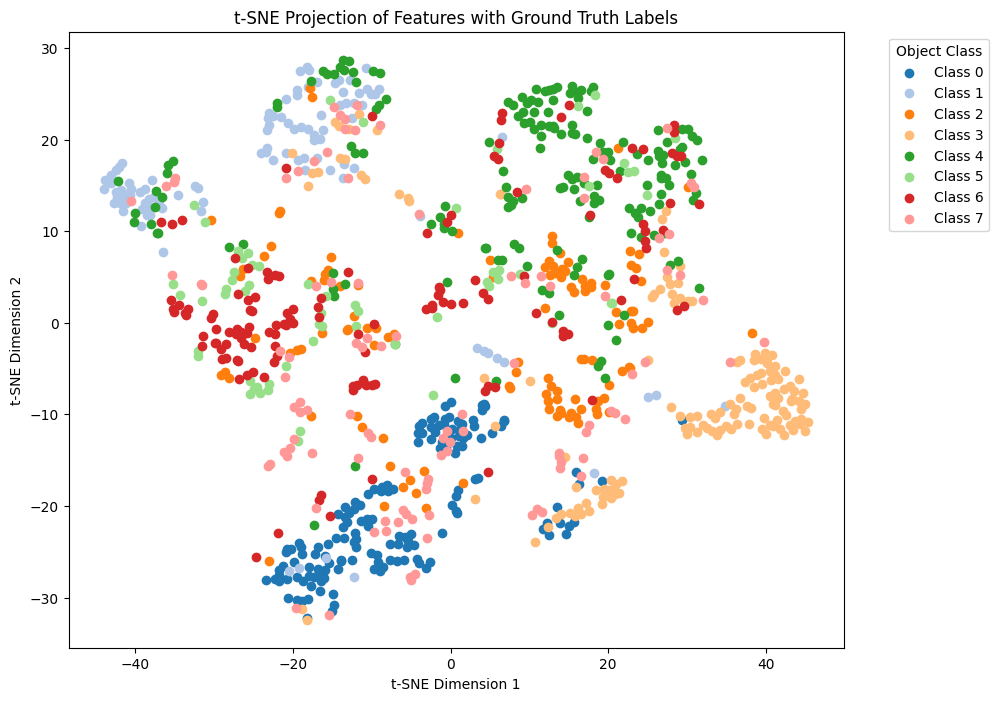

In [5]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_simple_seqlen_1_spec04-22-07:46:29/last.ckpt"
config_path = '/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_simple_seqlen_1_spec04-22-07:46:29/hparams.yaml'
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model
model.eval().cuda()

tsne_plot(config, model)

### sorting_imi_vg_simple_seqlen_1_mha_spec

Using GPU
Creating simple decoder
Total parameters: 36.105352 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


before torch.Size([1000, 256]) torch.Size([1000, 8])
after (1000, 256) (1000, 8)


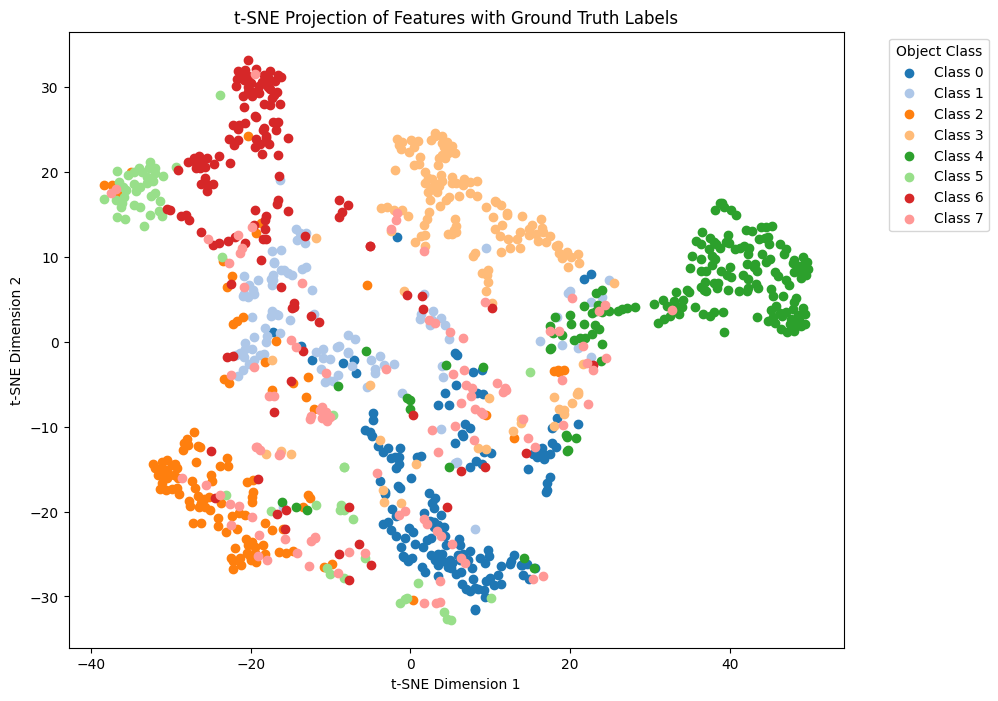

In [6]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_simple_seqlen_1_mha_spec04-22-04:18:40/last.ckpt"
config_path = '/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_simple_seqlen_1_mha_spec04-22-04:18:40/hparams.yaml'
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model.cuda()
model.eval()

tsne_plot(config, model)

### sorting_imi_vg_lstm_seqlen_3_mha_spec

Using GPU
Creating LSTM decoder
Total parameters: 36.534024 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


before torch.Size([1000, 256]) torch.Size([1000, 8])
after (1000, 256) (1000, 8)


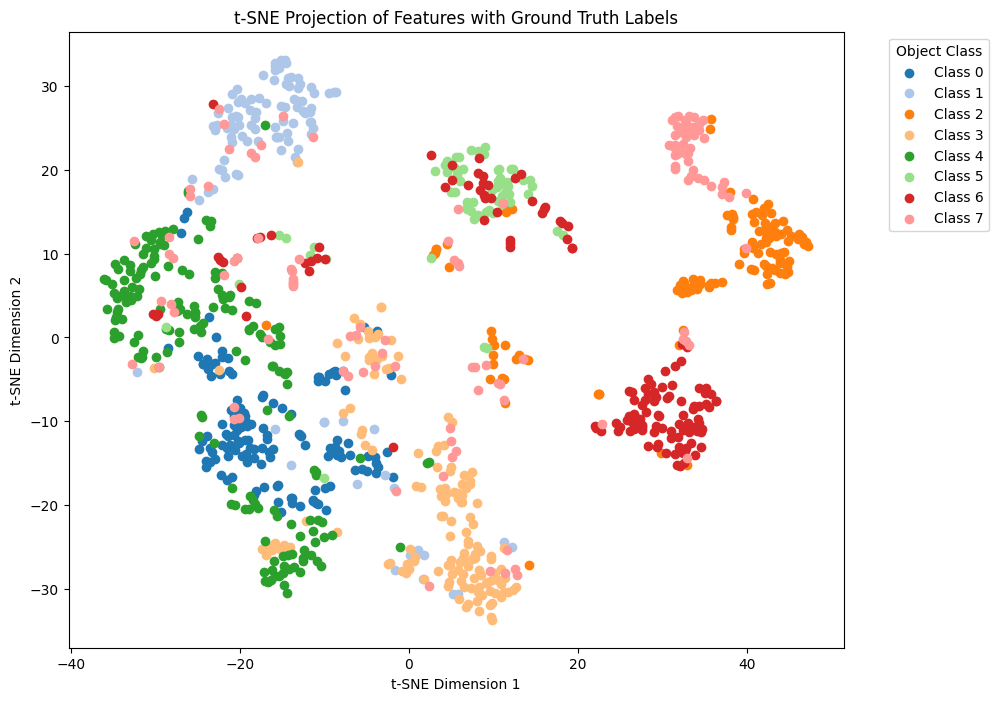

In [7]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_lstm_seqlen_3_mha_spec04-21-21:13:43/last.ckpt"
config_path = '/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_lstm_seqlen_3_mha_spec04-21-21:13:43/hparams.yaml'
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model.cuda()
model.eval()

tsne_plot(config, model, 1)

### sorting_imi_vg_lstm_seqlen_3_spec

Using GPU
Creating LSTM decoder
Total parameters: 27.090696 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


before torch.Size([1000, 256]) torch.Size([1000, 8])
after (1000, 256) (1000, 8)


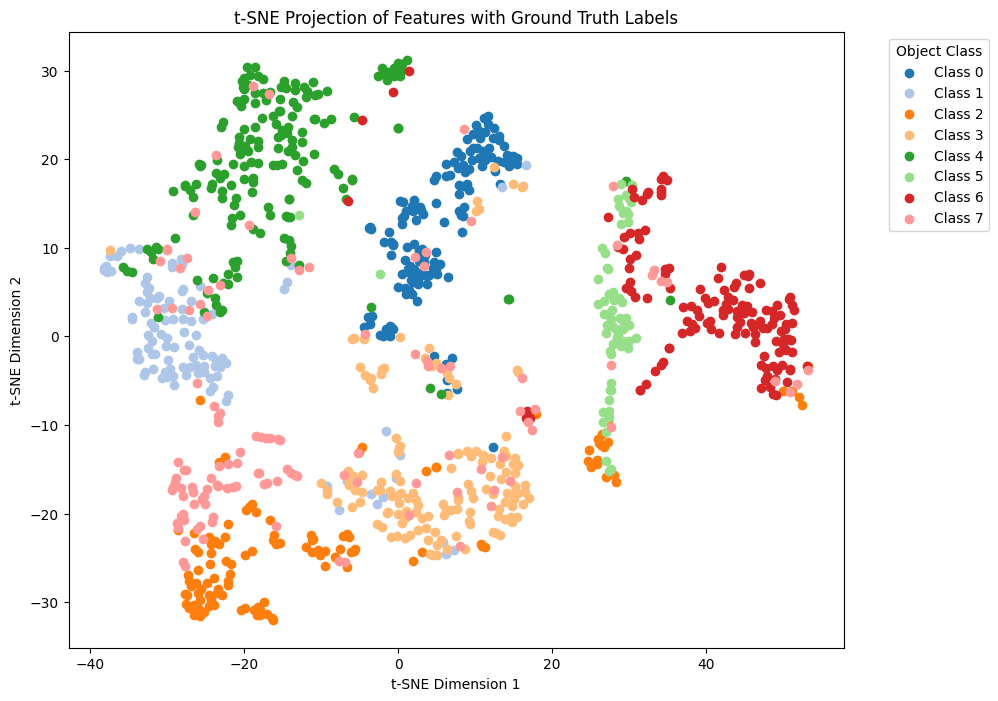

In [8]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_lstm_seqlen_3_spec04-22-00:48:38/last.ckpt"
config_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_lstm_seqlen_3_spec04-22-00:48:38/hparams.yaml"
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model.cuda()
model.eval()

tsne_plot(config, model, 1)

### sorting_imi_vg_ag_simple_seqlen_1_spec

Using GPU
Creating simple decoder
Total parameters: 29.02132 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20
Loading audio for ng/87
Loading audio for ng/94
Loading audio for ng/42
Loading audio for ng/98
Loading audio for ng/86
Loading audio for ng/80
Loading audio for ng/48
Loading audio for ng/16
Loading audio for ing/4
Loading audio for ng/97
Loading audio for ng/71
Loading audio for ng/78
Loading audio for ng/17
Loading audio for ng/83
Loading audio for ing/7
Loading audio for ng/69
Loading audio for ng/19
Loading audio for ng/56
Loading audio for ing/9
Loading audio for ng/88


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


before torch.Size([1000, 256]) torch.Size([1000, 8])
after (1000, 256) (1000, 8)


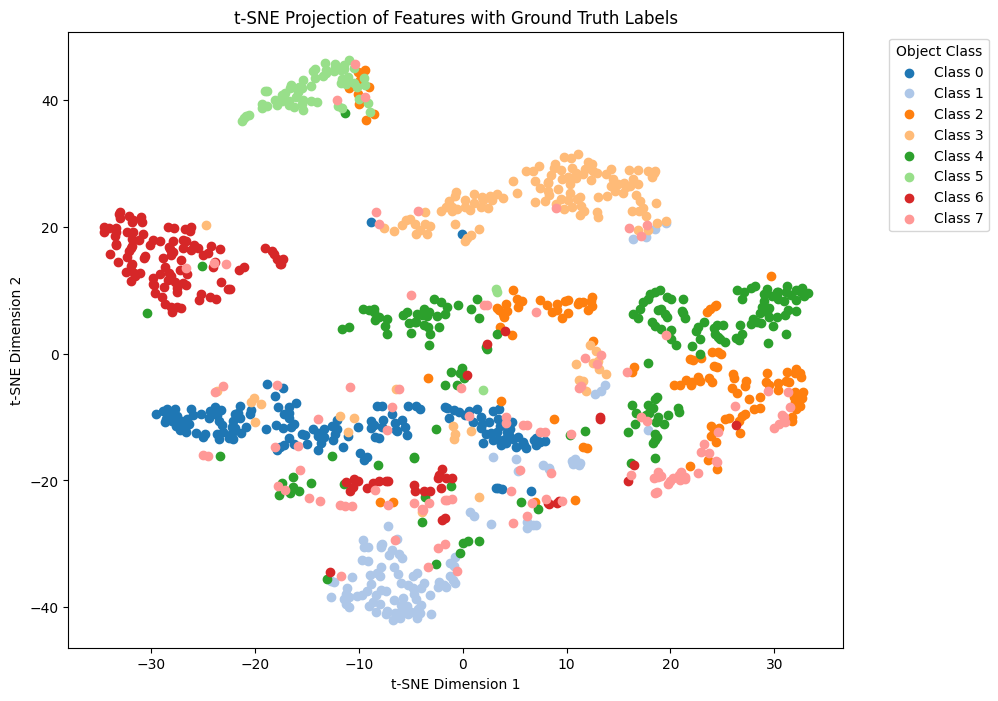

In [9]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_simple_seqlen_1_spec04-22-17:19:32/last.ckpt"
config_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_simple_seqlen_1_spec04-22-17:19:32/hparams.yaml"
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model.cuda()
model.eval()

tsne_plot(config, model)

### sorting_imi_vg_ag_simple_seqlen_1_mha_spec

Using GPU
Creating simple decoder
Total parameters: 38.464648 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20
Loading audio for ng/87
Loading audio for ng/94
Loading audio for ng/42
Loading audio for ng/98
Loading audio for ng/86
Loading audio for ng/80
Loading audio for ng/48
Loading audio for ng/16
Loading audio for ing/4
Loading audio for ng/97
Loading audio for ng/71
Loading audio for ng/78
Loading audio for ng/17
Loading audio for ng/83
Loading audio for ing/7
Loading audio for ng/69
Loading audio for ng/19
Loading audio for ng/56
Loading audio for ing/9
Loading audio for ng/88


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


before torch.Size([1000, 256]) torch.Size([1000, 8])
after (1000, 256) (1000, 8)


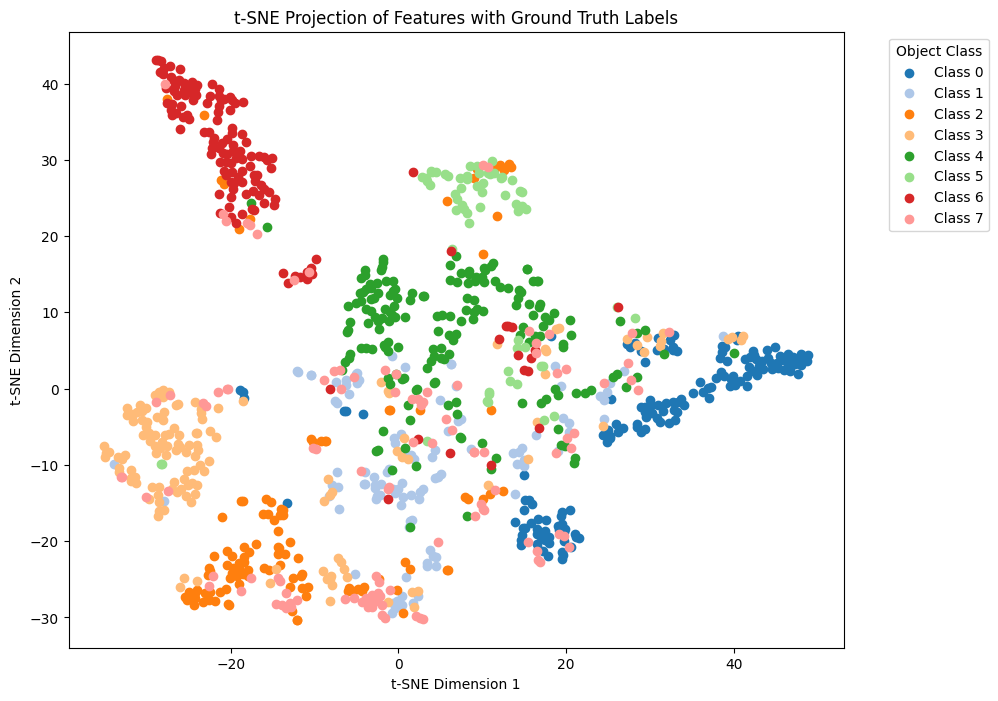

In [10]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_simple_seqlen_1_mha_spec04-22-15:08:58/last.ckpt"
config_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_simple_seqlen_1_mha_spec04-22-15:08:58/hparams.yaml"
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model.cuda()
model.eval()

tsne_plot(config, model)

### sorting_imi_vg_ag_lstm_seqlen_3_spec

Using GPU
Creating LSTM decoder
Total parameters: 29.449992 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20
Loading audio for ng/87
Loading audio for ng/94
Loading audio for ng/42
Loading audio for ng/98
Loading audio for ng/86
Loading audio for ng/80
Loading audio for ng/48
Loading audio for ng/16
Loading audio for ing/4
Loading audio for ng/97
Loading audio for ng/71
Loading audio for ng/78
Loading audio for ng/17
Loading audio for ng/83
Loading audio for ing/7
Loading audio for ng/69
Loading audio for ng/19
Loading audio for ng/56
Loading audio for ing/9
Loading audio for ng/88


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


before torch.Size([1000, 256]) torch.Size([1000, 8])
after (1000, 256) (1000, 8)


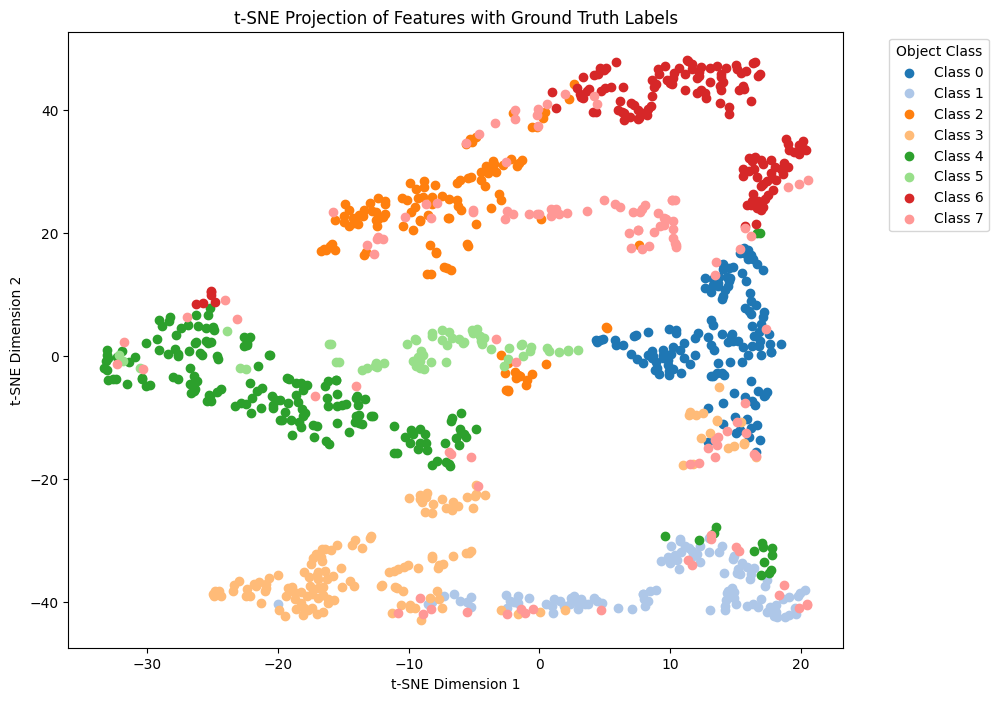

In [12]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_lstm_seqlen_3_spec04-22-21:39:20/last.ckpt"
config_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_lstm_seqlen_3_spec04-22-21:39:20/hparams.yaml"
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model.cuda()
model.eval()

tsne_plot(config, model,1)

### sorting_imi_vg_ag_lstm_seqlen_3_mha_spec

Using GPU
Creating LSTM decoder
Total parameters: 38.89332 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20
Loading audio for ng/87
Loading audio for ng/94
Loading audio for ng/42
Loading audio for ng/98
Loading audio for ng/86
Loading audio for ng/80
Loading audio for ng/48
Loading audio for ng/16
Loading audio for ing/4
Loading audio for ng/97
Loading audio for ng/71
Loading audio for ng/78
Loading audio for ng/17
Loading audio for ng/83
Loading audio for ing/7
Loading audio for ng/69
Loading audio for ng/19
Loading audio for ng/56
Loading audio for ing/9
Loading audio for ng/88


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


before torch.Size([1000, 256]) torch.Size([1000, 8])
after (1000, 256) (1000, 8)


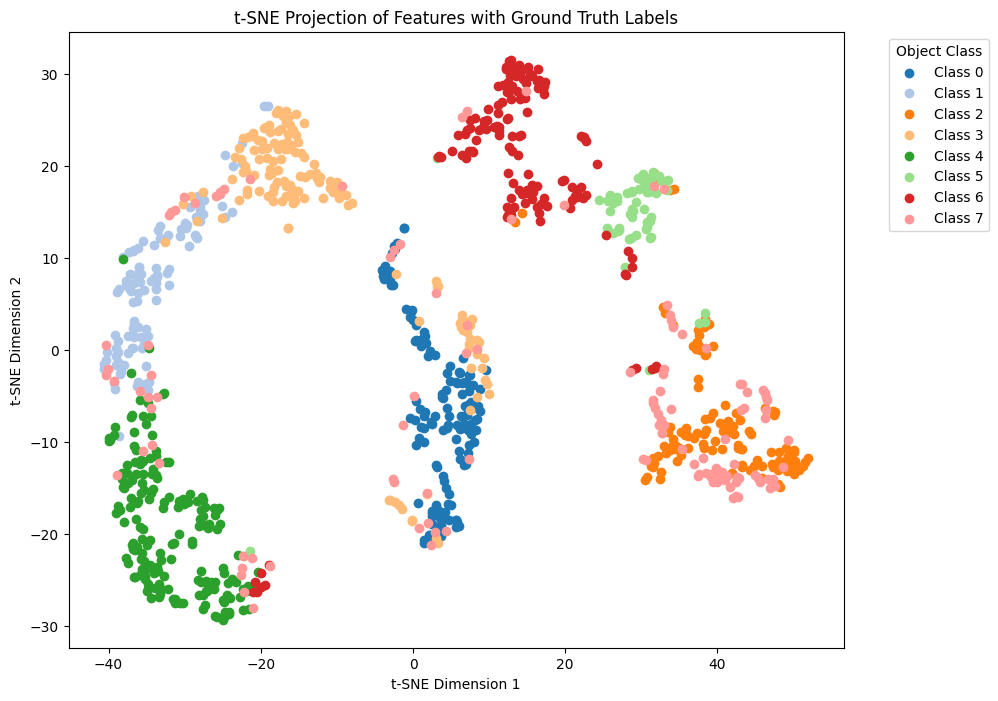

In [13]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_lstm_seqlen_3_mha_spec04-22-19:26:28/last.ckpt"
config_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_lstm_seqlen_3_mha_spec04-22-19:26:28/hparams.yaml"
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model.cuda()
model.eval()

tsne_plot(config, model, 1)

### sorting_imi_vg_ag_lstm_seqlen_3_mha_spec_pretrained

Using GPU
Creating LSTM decoder
Total parameters: 38.89332 Million
NUM STACK:  6
Train episodes:  79
Val episodes:  20
Loading audio for ng/87
Loading audio for ng/94
Loading audio for ng/42
Loading audio for ng/98
Loading audio for ng/86
Loading audio for ng/80
Loading audio for ng/48
Loading audio for ng/16
Loading audio for ing/4
Loading audio for ng/97
Loading audio for ng/71
Loading audio for ng/78
Loading audio for ng/17
Loading audio for ng/83
Loading audio for ing/7
Loading audio for ng/69
Loading audio for ng/19
Loading audio for ng/56
Loading audio for ing/9
Loading audio for ng/88


/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/punygod_admin/miniconda3/envs/muls/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


before torch.Size([1000, 256]) torch.Size([1000, 8])
after (1000, 256) (1000, 8)


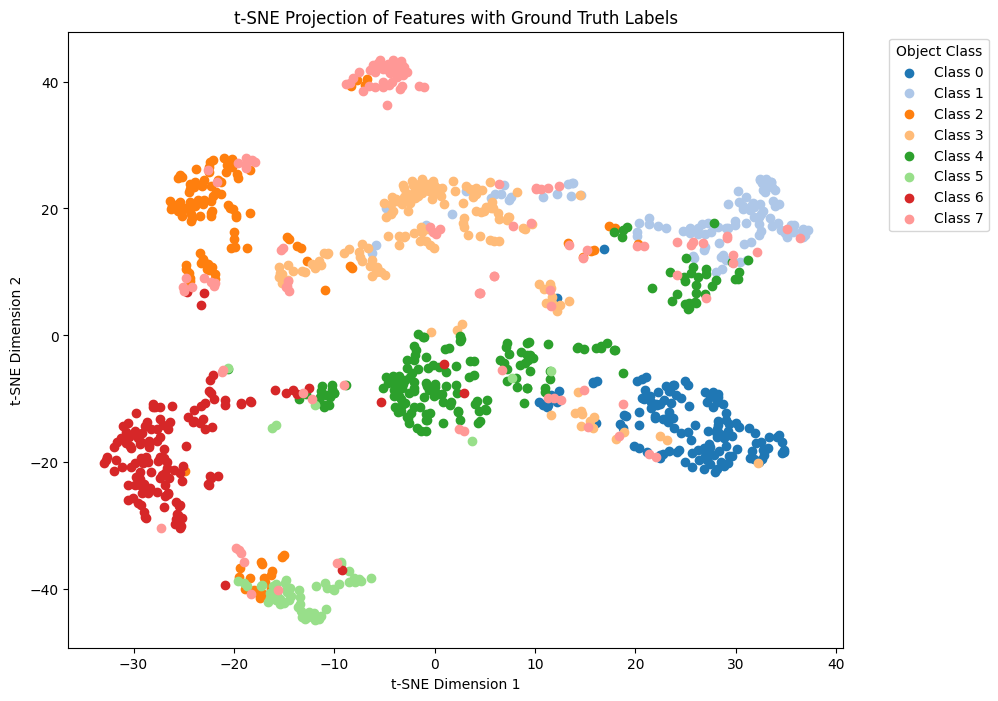

In [14]:
model_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_lstm_seqlen_3_mha_spec_pretrained04-24-17:22:04/last.ckpt"
config_path = "/home/punygod_admin/SoundSense/soundsense/models/baselines/mulsa/lightning_logs/sorting_imi_vg_ag_lstm_seqlen_3_mha_spec_pretrained04-24-17:22:04/hparams.yaml"
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
model = MULSAInference(config_path)

# Load the model from the checkpoint
model.load_state_dict(
        torch.load(
            model_path,
            map_location=torch.device("cpu"),
        )['state_dict']
    )
# model = model.load_from_checkpoint(model_path)

# Then, move the model to CUDA device
model = model.cuda()
model.eval()

tsne_plot(config, model, 1)